In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
from tensorflow.keras import metrics
import pandas as pd
from loss_functions import sigma_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma
import keras_tuner
fval=0.1
n_train=100000
f_tune=0.1

2023-05-08 18:12:13.399089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 18:12:14.729757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-08 18:12:14.729884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-08 18:12:14.729901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, kt):
        reduce_lr_on_plateau =True# False
        lr=kt.Float("lr", min_value=2e-5, max_value=2*1e-3, step=2, sampling="log")#0.001 #steps=log_2(max/min)=7.6
        drop_rate=kt.Float("drop_rate", min_value=0.1, max_value=0.6, step=0.1)#0.2 
        #activation_funct=kt.Choice("activation_funct", ["relu", "tanh"])#relu

        shape = (hp.nside2npix(nside), 2)
        inputs = tf.keras.layers.Input(shape)
        # nside 16 -> 8
        x = nnhealpix.layers.ConvNeighbours(nside, filters=32, kernel_size=9)(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        x = nnhealpix.layers.Dgrade(nside, nside//2)(x)
        # nside 8 -> 4
        x = nnhealpix.layers.ConvNeighbours(nside//2, filters=32, kernel_size=9)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = nnhealpix.layers.Dgrade(nside//2, nside//4)(x)
        # nside 4 -> 2
        x = nnhealpix.layers.ConvNeighbours(nside//4, filters=32, kernel_size=9)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = nnhealpix.layers.Dgrade(nside//4, nside//8)(x)
        # nside 2 -> 1
        x = nnhealpix.layers.ConvNeighbours(nside//8, filters=32, kernel_size=9)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = nnhealpix.layers.Dgrade(nside//8, nside//16)(x)
        # dropout
        x = tf.keras.layers.Dropout(drop_rate)(x)
        x = tf.keras.layers.Flatten()(x)
        #for i in range(kt.Int("num_layers", 1, 2)):
            #x = tf.keras.layers.Dense(kt.Int(f"n_layers_{i}", min_value=8, max_value=256, step=2, sampling="log"))(x)#steps=5
            #x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dense(kt.Int("n_layers_0", min_value=16, max_value=256, step=2, sampling="log"))(x)#steps=5
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(drop_rate)(x)
        x = tf.keras.layers.Dense(kt.Int("n_layers_1", min_value=16, max_value=256, step=2, sampling="log"))(x)#steps=5
        x = tf.keras.layers.Activation('relu')(x)
        out = tf.keras.layers.Dense(2)(x)

        tf.keras.backend.clear_session()
        model = tf.keras.models.Model(inputs=inputs, outputs=out)
        metrics=[sigma_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
        loss_funct=2 #kt.Choice("loss_funct", [0, 2])#relu
        model.compile(loss=metrics[loss_funct], optimizer=tf.optimizers.Adam(learning_rate=lr),metrics=metrics[0])
        return model
    def fit(self,kt,model, x, y, validation_data=None, batch_size=None, shuffle=None , **kwargs):
        n_tune=int(n_train*f_tune)
        n_val=int(n_tune*fval)
        batch_size=kt.Int("batch_size", 16, 128, step=2, sampling="log" )#32 , steps=7.5
        p_stopping=20
        p_reduce=kt.Int("p_reduce", min_value=2, max_value=20, step=2)#5, steps=9
        f_reduce=kt.Float("f_reduce", min_value=0.1, max_value=0.8, step=0.1)
        stop_to_monitor="val_loss"
        reduce_to_monitor="val_loss"
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor=stop_to_monitor,patience=p_stopping) #,mode='min')
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=reduce_to_monitor, factor=f_reduce,patience=p_reduce)
        self.callbacks = kwargs.get('callbacks')+[early_stopping,reduce_lr]
        x,y=unison_shuffled_copies(x, y)
        tot=n_tune-n_val
        R=tot%batch_size
        x_train=x[:tot-R]
        x_val=x[tot-R:n_tune+1]
        y_train=y[:tot-R]
        y_val=y[tot-R:n_tune+1]
        print(x_train.shape,y_train.shape, x_val.shape, y_val.shape)
        if loss_training==sigma_batch_loss:
            print("yes_this_loss")
            y_train, x_train = unison_sorted_copies(y_train, x_train)
            list_length=int(len(y_train)/batch_size)
            lista=np.zeros(shape=(list_length,batch_size,y_train.shape[1]))
            lista_2=np.zeros(shape=(list_length,batch_size,x_train.shape[1],x_train.shape[2]))
            for i in range(list_length):
                for j in range(batch_size):
                    lista[i,j]=y_train[batch_size*i+j]
                    lista_2[i,j]=x_train[batch_size*i+j]
            lista , lista_2 = unison_shuffled_copies(lista, lista_2)
            for i in range(list_length):
                for j in range(batch_size):
                    y_train[batch_size*i+j]=lista[i,j]
                    x_train[batch_size*i+j]=lista_2[i,j]
            return model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=batch_size, shuffle=False, **kwargs)
        else:
            return model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=batch_size, **kwargs)

In [3]:
home_dir='/home/amorelli/r_estimate/B_maps_white_noise/tuning'
#RandomSearch
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective="val_loss",
    max_trials=50,
    executions_per_trial=3,
    directory=home_dir,
    overwrite=False,
    project_name="3_5_23"
)
print("tuner search space summary:","/n",tuner.search_space_summary())

INFO:tensorflow:Reloading Tuner from /home/amorelli/r_estimate/B_maps_white_noise/tuning/3_5_23/tuner0.json
Search space summary
Default search space size: 7
lr (Float)
{'default': 2e-05, 'conditions': [], 'min_value': 2e-05, 'max_value': 0.002, 'step': 2, 'sampling': 'log'}
drop_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
n_layers_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 2, 'sampling': 'log'}
n_layers_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 2, 'sampling': 'log'}
batch_size (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 2, 'sampling': 'log'}
p_reduce (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 2, 'sampling': 'linear'}
f_reduce (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
tuner 

In [4]:
tuner.results_summary(10)

Results summary
Results in /home/amorelli/r_estimate/B_maps_white_noise/tuning/3_5_23
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 23 summary
Hyperparameters:
lr: 8e-05
drop_rate: 0.1
n_layers_0: 64
n_layers_1: 64
batch_size: 16
p_reduce: 4
f_reduce: 0.30000000000000004
Score: 0.00016764422374156615

Trial 21 summary
Hyperparameters:
lr: 4e-05
drop_rate: 0.30000000000000004
n_layers_0: 128
n_layers_1: 32
batch_size: 16
p_reduce: 14
f_reduce: 0.4
Score: 0.00016988449594161162

Trial 31 summary
Hyperparameters:
lr: 4e-05
drop_rate: 0.1
n_layers_0: 16
n_layers_1: 16
batch_size: 16
p_reduce: 20
f_reduce: 0.1
Score: 0.00017837737686932087

Trial 28 summary
Hyperparameters:
lr: 0.00016
drop_rate: 0.1
n_layers_0: 32
n_layers_1: 64
batch_size: 16
p_reduce: 18
f_reduce: 0.8
Score: 0.00018190826813224703

Trial 36 summary
Hyperparameters:
lr: 0.00032
drop_rate: 0.1
n_layers_0: 256
n_layers_1: 16
batch_size: 16
p_reduce: 20
f_reduce: 0.1
Score: 0.00019295668365278593


In [5]:
nside=16
models = tuner.get_best_models(num_models=2)
best_model = models[0]
print(type(best_model))
best_model.summary()

2023-05-08 18:12:17.072149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-08 18:12:17.072236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-05-08 18:12:17.073165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'keras.engine.functional.Functional'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072, 2)]         0         
                                                                 
 order_map (OrderMap)        (None, 27648, 2)          0         
                                                                 
 conv1d (Conv1D)             (None, 3072, 32)          576       
                                                                 
 activation (Activation)     (None, 3072, 32)          0         
                                                                 
 order_map_1 (OrderMap)      (None, 3072, 32)          0         
                                                                 
 average_pooling1d (AverageP  (None, 768, 32)          0         
 ooling1D)                                                       
                

In [6]:
best_hp = tuner.get_best_hyperparameters(100)
#model = tuner.hypermodel.build(best_hp[0])
print(best_hp[0].values)

{'lr': 8e-05, 'drop_rate': 0.1, 'n_layers_0': 64, 'n_layers_1': 64, 'batch_size': 16, 'p_reduce': 4, 'f_reduce': 0.30000000000000004}


In [7]:
print(best_hp[0].values.keys())
keys=[]
for key in best_hp[0].values.keys():
    if type(best_hp[0].values[key]) != type("s"):
        keys.append(key)
print(keys)

dict_keys(['lr', 'drop_rate', 'n_layers_0', 'n_layers_1', 'batch_size', 'p_reduce', 'f_reduce'])
['lr', 'drop_rate', 'n_layers_0', 'n_layers_1', 'batch_size', 'p_reduce', 'f_reduce']


In [11]:
x_axis=range(len(best_hp))
d={}
for key in keys:
    #print(key,type(best_hp[0].values[key]))
    d[key]=[best_hp[x].get(key) for x in x_axis]
data=pd.DataFrame(d)
running_data= data.rolling(window=5).mean()
#print(lr[:10])

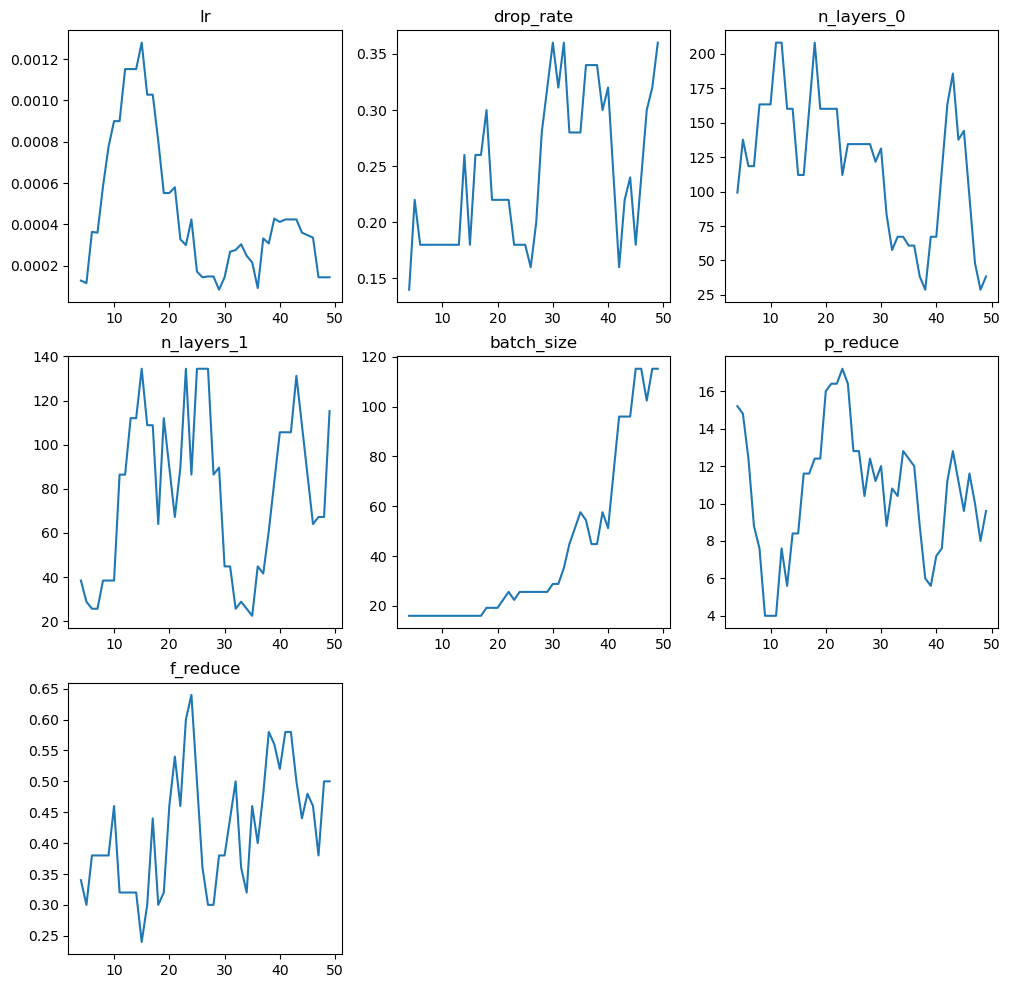

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
for i,key in enumerate(keys):
    plt.subplot(3,3,i+1)
    plt.plot(x_axis,running_data[key])
    plt.title(key)

In [10]:
print(running_data["lr"][:10])

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9    0.000452
Name: lr, dtype: float64
